In [ ]:
#default_exp common.datablock

# Datablock
> Recipes for handling data not in a standard format.

 The fastai documentation already has excellent examples of the Datablock API, you can find it [here](https://github.com/fastai/fastai2/blob/master/nbs/50_tutorial.datablock.ipynb). Because of that I'll focus on more peculiar use cases here.  
If you want a more detailed view take a look at [this](https://muellerzr.github.io/fastblog/datablock/2020/03/21/DataBlockAPI.html) blog post or at the second chapter of [fastbook](https://github.com/fastai/fastbook/blob/master/02_production.ipynb) (scroll down to the *From data to DataLoaders* section).

## Required imports and common setup

In [ ]:
from fastai2.vision.all import *

In [ ]:
source = untar_data(URLs.PETS)/'images'
fns = get_image_files(source)
fn = fns[0]

## Custom types

### Simple

Let's change a bit how black and white images are displayed. By default, `PILImageBW` uses the `Greys` colormap for displaying the images, this works well for `MNIST` but doesn't look so good for normal images:

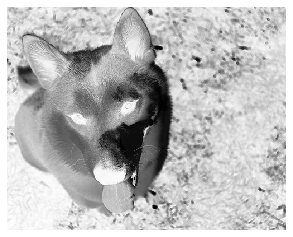

In [ ]:
im = PILImageBW.create(fn); im.show();

As we can see, this color maps inverts black and white, a more natural way of displaying this image would be with the `gray` colormap:

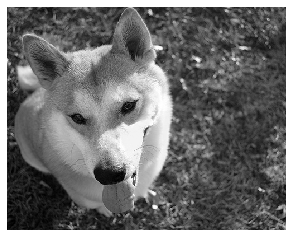

In [ ]:
im.show(cmap='gray');

So we can create a class that uses this colormap instead:

In [ ]:
class PILImageBW2(PILImageBW): _show_args = {'cmap': 'gray'}

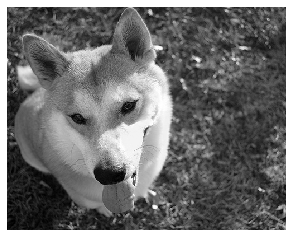

In [ ]:
im = PILImageBW2.create(fn)
im.show();

If we want the changes to also be applied to `show_batch` we need to make an additional modification, we have to make sure that when our image gets converted to a tensor it maintains the new `_show_args` we just defined (else it goes back to the `_show_args` from `PILImageBW`).  
**Note:** Try creating the datablock without running the below cell and check what happens.

In [ ]:
class TensorImageBW2(TensorImage): _show_args = PILImageBW2._show_args
PILImageBW2._tensor_cls = TensorImageBW2

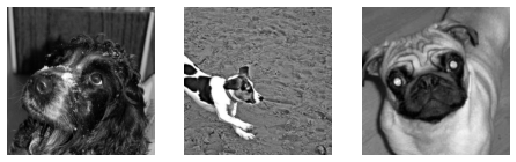

In [ ]:
dblock = DataBlock((ImageBlock(PILImageBW2)), get_items=get_image_files,
                   item_tfms=[Resize(128)])
dls = dblock.dataloaders(source)
dls.show_batch(nrows=1, max_n=3)

### Custom `TransformBlock` and `show` method
> How to create a new block for the mid-level API.

Let's say we have a task where we want to predict the race of a pet. Normally we do this by just looking at an image of the pet, but let's say that for this task, we also have an additional information, the weight of the pet!  
How do we handle that?

In [ ]:
class ImageWeight(Tuple):
  @classmethod
  def create(cls, fnw): return cls(PILImage.create(fnw[0]), tensor(fnw[1]))
  def show(self, ctx=None, **kwargs):
    return show_image(self[0], title=str(self[1]), ctx=ctx, **kwargs)

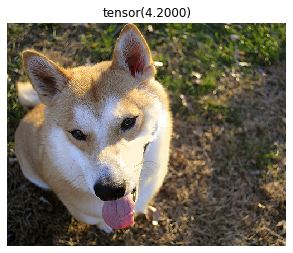

In [ ]:
im = ImageWeight.create([fn, 4.2]); im.show();

In [ ]:
def ImageWeightBlock(): return TransformBlock(type_tfms=ImageWeight.create,
                                              batch_tfms=IntToFloatTensor)

In [ ]:
def random_weight(): return np.random.uniform(1,8)

In [ ]:
def get_items(source):
  fns = get_image_files(source)
  return fns.map(lambda o: [o, random_weight()])

In [ ]:
dblock = DataBlock((ImageWeightBlock, CategoryBlock), get_items=get_items,
                   get_y=[[itemgetter(0), RegexLabeller(r'^.*\/(.*)_\d+.jpg$')]],
                   item_tfms=[Resize(128)])

In [ ]:
dls = dblock.dataloaders(source)

In [ ]:
@typedispatch
def show_batch(x:ImageWeight, y, samples, **kwargs):
  return show_batch[TensorImage](x, y, samples, **kwargs)

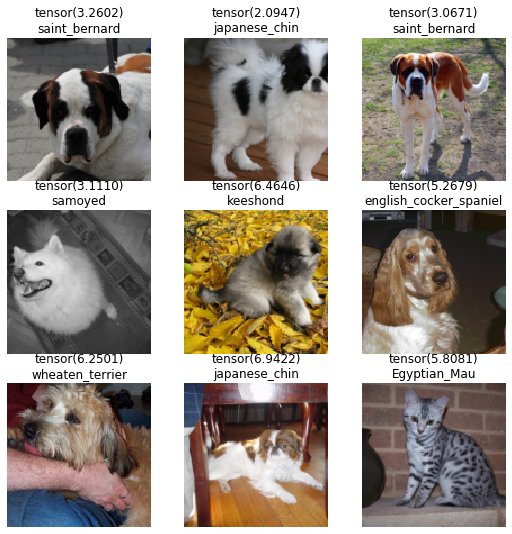

In [ ]:
dls.show_batch()

**Further reading:** Check [this](http://dev.fast.ai/tutorial.siamese#Writing-your-custom-data-block) for a siamese datablock tutorial.

## Check transforms on a single item

Unsure if your augmentation transforms are too wild? Check variatons on a single item by passing `unique=True` to `show_batch`!

In [ ]:
dblock = DataBlock((ImageBlock), get_items=get_image_files,
                  item_tfms=[Resize(256)],
                  batch_tfms=[*aug_transforms(size=224)])

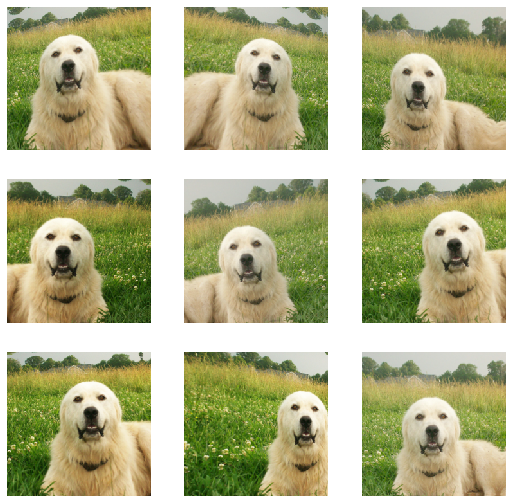

In [ ]:
dls = dblock.dataloaders(source)
dls.show_batch(unique=True)